# Exploring Therapist Labels

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from emonet import DATA_DIR
from emonet.data_prep import from_json, to_records

/Users/christophersantiago/opt/miniconda3/envs/emonet2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

Our dataset metadata is nested in JSON format:

```python
{'filename':
 {'therapist': 
  {'emotion': 'rating'}
 },
 {'therapist': 
  {'emotion': 'rating'}
 },
 ...
}
```

The `to_records()` function converts the nested metadata into a list of records, which we can then read into a `DataFrame` object:

In [3]:
meta = from_json(DATA_DIR.joinpath('metadata.json'))
labels = pd.DataFrame.from_records(to_records(meta))
labels

,key,duration,therapist,fear,anger,happy,neutral,sadness
0,52756_53113_1578268800,51.012000,Michelle Lyn,medium,high,none,none,low
1,8953_39117_1675385984,20.508000,Michelle Lyn,none,none,none,none,low
2,5370_39117_3035921039,40.764000,Michelle Lyn,low,none,none,none,low
3,9926_39117_4164936498,3.756000,Michelle Lyn,none,none,none,none,low
4,53490_53113_1577059200,31.678000,Michelle Lyn,low,low,none,none,low
...,...,...,...,...,...,...,...,...
4203,6708_53113_1576800000,42.431375,Yared Alemu,low,low,none,none,medium
4204,4644_53113_1601251200,13.908000,Yared Alemu,none,none,none,none,low
4205,1940_39117_1834701346,21.792687,Yared Alemu,low,low,none,none,low
4206,7010_53113_1571184000,32.646000,Yared Alemu,low,medium,none,none,low


## Audio Length

We have 1,055 audio files, with an average duration of 53 seconds. Note, however, that our shortest duration is less than 1 second; our longest is over 6 minutes. We'll need to account for these varying lengths through a series of pre-processing steps, that might include:

- VAD (voice activity detection)
- batch sorting by duration / tensor length
- random sampling of fixed-length clips 
- padding tensors within each batch

There are also some pre-trained models (e.g. Wave2Vec2) that accept varying-length audio files; we could use these as feature extraction within the first layer(s) of our network.

In [4]:
labels[['key', 'duration']].drop_duplicates().describe()

,duration
count,1052.000000
mean,34.828298
std,17.777119
min,0.444000
25%,23.681531
50%,31.911000
75%,42.393375
max,150.504000


In [5]:
labels['duration'].drop_duplicates().sort_values().reset_index(drop=True)[:10]

0    0.444000
1    1.656000
2    2.682000
3    2.722812
4    3.096000
5    3.288000
6    3.368688
7    3.756000
8    3.768000
9    3.924000
Name: duration, dtype: float64

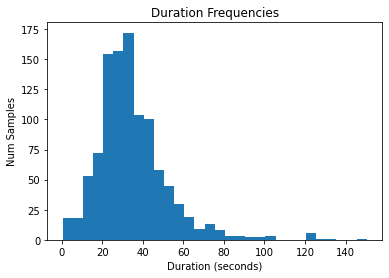

In [6]:
labels.loc[:, ['key', 'duration']].drop_duplicates().hist('duration', bins=30, grid=False)
plt.ylabel('Num Samples')
plt.xlabel('Duration (seconds)')
plt.title('Duration Frequencies')
plt.show()

## Ratings

We'll create a melted dataset for exploring therapist ratings.

In [7]:
melted = labels.melt(
    id_vars='therapist', 
    value_vars=['fear', 'anger', 'happy', 'neutral', 'sadness'], 
    var_name='emotion', 
    value_name='rating'
)
melted

,therapist,emotion,rating
0,Michelle Lyn,fear,medium
1,Michelle Lyn,fear,none
2,Michelle Lyn,fear,low
3,Michelle Lyn,fear,none
4,Michelle Lyn,fear,low
...,...,...,...
21035,Yared Alemu,sadness,medium
21036,Yared Alemu,sadness,low
21037,Yared Alemu,sadness,low
21038,Yared Alemu,sadness,low


### Aggregate Labels

At an aggregate level, we see most emotions rated at `none`, and the least amount rated at `high`.

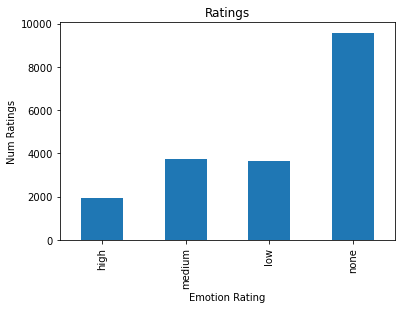

In [8]:
sort_by = ['high', 'medium', 'low', 'none']
melted.groupby('rating').size()[sort_by].plot(kind='bar')
plt.ylabel('Num Ratings')
plt.xlabel('Emotion Rating')
plt.title('Ratings')
plt.show()

### Emotion Labels (Binary)

At an emotion level, we see that `fear` is balanced, `sadness` is slightly imbalanced, and `anger` is imbalanced nearly 3:1.

In [30]:
from emonet.utils import binarize_ratings, get_rating_encoder
from emonet.utils import RATINGS

enc = get_rating_encoder(RATINGS)
labs = [binarize_ratings(r) for r in [enc.lab2ind[x] for x in melted['rating'].dropna()]]

/var/folders/3b/_8byt87n54x1wvb7m6kz2l3r0000gp/T/ipykernel_12347/3177619008.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating'] = [binarize_ratings(r) for r in [enc.lab2ind[x] for x in melted['rating'].dropna()]]


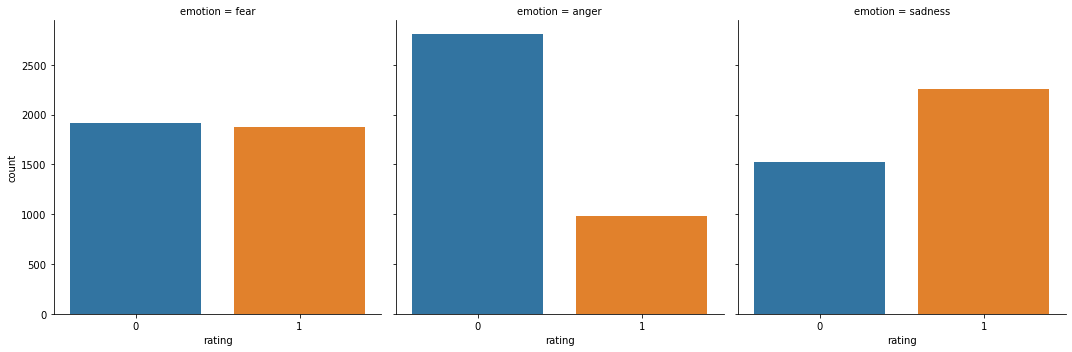

In [47]:
df = melted.dropna()
mask = df['emotion'].isin(['fear', 'anger', 'sadness'])
df['rating'] = [binarize_ratings(r) for r in [enc.lab2ind[x] for x in melted['rating'].dropna()]]

sns.catplot(
    x="rating", col="emotion",
    data=df[mask], kind="count",
)

plt.show()

### Ratings by Emotion and Therapist

Broken down in this way, we can see some divergence in rating severity across the therapists and emotions:

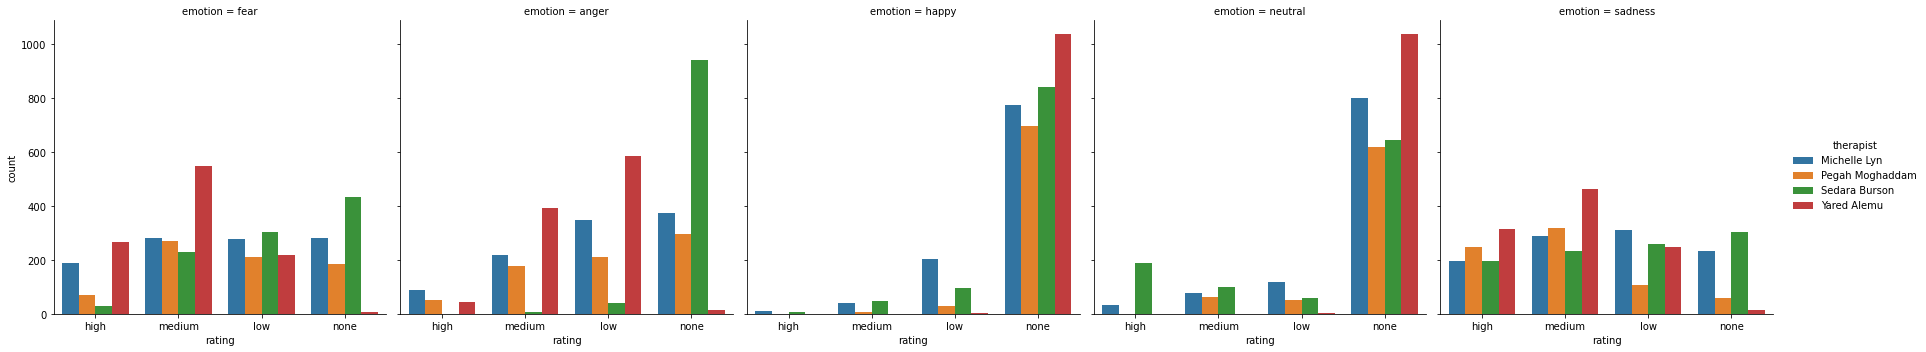

In [9]:
sns.catplot(
    x="rating", hue="therapist", col="emotion",
    data=melted, kind="count", order=sort_by, # col_wrap=3, 
)

plt.show()

-------

In [11]:
def therapist_emotion_rating_counts(df):
    melted = df.melt(id_vars='therapist', value_vars=['fear', 'anger', 'happy', 'neutral', 'sadness'], var_name='emotion', value_name='rating')
    grouped = melted.groupby(['therapist', 'emotion', 'rating']).size().reset_index()
    return grouped.rename({0: 'count'}, axis=1)


def therapist_ratings(df, therapist):
    mask = df['therapist'] == therapist
    melted = df[mask].melt(id_vars='therapist', value_vars=['fear', 'anger', 'happy', 'neutral', 'sadness'], var_name='emotion', value_name='rating')
    grouped = melted.groupby(['emotion', 'rating']).count().reset_index()
    grouped.rename({'therapist': 'count'}, axis=1, inplace=True)
    return grouped


def ratings_by_emotion(df, emotion):
    counts = therapist_emotion_rating_counts(df)
    mask = counts['emotion'] == emotion
    return counts[mask]


In [12]:
therapist_emotion_rating_counts(labels)

,therapist,emotion,rating,count
0,Michelle Lyn,anger,high,90
1,Michelle Lyn,anger,low,346
2,Michelle Lyn,anger,medium,216
3,Michelle Lyn,anger,none,374
4,Michelle Lyn,fear,high,189
...,...,...,...,...
68,Yared Alemu,neutral,none,1035
69,Yared Alemu,sadness,high,314
70,Yared Alemu,sadness,low,246
71,Yared Alemu,sadness,medium,464


In [13]:
therapist_ratings(labels, 'Michelle Lyn')

,emotion,rating,count
0,anger,high,90
1,anger,low,346
2,anger,medium,216
3,anger,none,374
4,fear,high,189
5,fear,low,277
6,fear,medium,280
7,fear,none,280
8,happy,high,9
9,happy,low,203


In [14]:
for emotion in melted['emotion'].unique():
    print(ratings_by_emotion(labels, emotion))
    print('\n')

          therapist emotion  rating  count
4      Michelle Lyn    fear    high    189
5      Michelle Lyn    fear     low    277
6      Michelle Lyn    fear  medium    280
7      Michelle Lyn    fear    none    280
24  Pegah Moghaddam    fear    high     69
25  Pegah Moghaddam    fear     low    210
26  Pegah Moghaddam    fear  medium    268
27  Pegah Moghaddam    fear    none    188
41    Sedara Burson    fear    high     28
42    Sedara Burson    fear     low    302
43    Sedara Burson    fear  medium    228
44    Sedara Burson    fear    none    431
61      Yared Alemu    fear    high    265
62      Yared Alemu    fear     low    219
63      Yared Alemu    fear  medium    546
64      Yared Alemu    fear    none      7


          therapist emotion  rating  count
0      Michelle Lyn   anger    high     90
1      Michelle Lyn   anger     low    346
2      Michelle Lyn   anger  medium    216
3      Michelle Lyn   anger    none    374
20  Pegah Moghaddam   anger    high     52
21  Pegah

## Find Weights to Balance Classes

In [15]:
out = []
for emotion in ['anger', 'fear', 'sadness']:
    grouped = ratings_by_emotion(labels, emotion).groupby(['therapist', 'rating']).sum() / ratings_by_emotion(labels, emotion).groupby(['therapist']).sum()
    weights = grouped.reset_index().groupby('therapist').max()/grouped
    res = pd.concat([grouped, weights], axis=1).drop('rating', axis=1)
    res.columns = ['pct_labels', 'weighted_bal']
    res['emotion'] = emotion
    print(emotion)
    print(res)
    print('\n')
    out.append(res)
    res.to_csv(f'{emotion}_weights.csv')

anger
                        pct_labels  weighted_bal emotion
therapist       rating                                  
Michelle Lyn    high      0.087719      4.155556   anger
                low       0.337232      1.080925   anger
                medium    0.210526      1.731481   anger
                none      0.364522      1.000000   anger
Pegah Moghaddam high      0.070748      5.711538   anger
                low       0.285714      1.414286   anger
                medium    0.239456      1.687500   anger
                none      0.404082      1.000000   anger
Sedara Burson   low       0.040445     23.525000   anger
                medium    0.008089    117.625000   anger
                none      0.951466      1.000000   anger
Yared Alemu     high      0.042430     13.295455   anger
                low       0.564127      1.000000   anger
                medium    0.378978      1.488550   anger
                none      0.014465     39.000000   anger


fear
                  

In [71]:
from collections import defaultdict

order = ['none', 'low', 'medium', 'high']
weights_out = pd.concat(out).reset_index().groupby(['therapist', 'emotion', 'rating']).sum()['weighted_bal'].reset_index()
weights_out = weights_out.pivot(index=['therapist', 'emotion'], columns='rating', values='weighted_bal')[order].reset_index().fillna(100.)
# note filling NA with 100. since it's obviously rare

weights_out
weights = defaultdict(dict)
for _, row in weights_out.iterrows():
    weights[row['therapist']][row['emotion']] = list(row[2:])

In [72]:
import json

json.dumps(weights)

'{"Michelle Lyn": {"anger": [1.0, 1.0809248554913296, 1.7314814814814814, 4.155555555555556], "fear": [1.0, 1.0108303249097472, 1.0, 1.4814814814814814], "sadness": [1.3304721030042919, 1.0, 1.0801393728222994, 1.5816326530612246]}, "Pegah Moghaddam": {"anger": [1.0, 1.4142857142857144, 1.6875, 5.711538461538462], "fear": [1.425531914893617, 1.2761904761904763, 1.0, 3.8840579710144927], "sadness": [5.19672131147541, 2.9626168224299065, 1.0, 1.268]}, "Sedara Burson": {"anger": [1.0, 23.525000000000002, 117.625, 100.0], "fear": [1.0, 1.4271523178807948, 1.8903508771929827, 15.392857142857144], "sadness": [1.0, 1.1828793774319069, 1.316017316017316, 1.5431472081218276]}, "Yared Alemu": {"anger": [39.0, 1.0, 1.4885496183206106, 13.295454545454545], "fear": [78.0, 2.493150684931507, 1.0, 2.060377358490566], "sadness": [35.69230769230769, 1.8861788617886182, 1.0, 1.4777070063694269]}}'

## Correlations Across Therapists and Emotions

In [14]:
ratings_across_files = labels.melt(
    id_vars=['therapist', 'key'],
    value_vars=['fear', 'anger', 'happy', 'neutral', 'sadness'], 
    var_name='emotion', 
    value_name='rating'
).pivot(index=['therapist','emotion'], columns='key').fillna('none').sort_index(level=1)

new_index = [f'{x[0].split()[0]}-{x[1]}' for x in ratings_across_files.index]
rating_mapper = {'none': 0, 'low': 1, 'medium': 2, 'high': 3}

ratings_across_files.reset_index(drop=True, inplace=True)
ratings_across_files.index = new_index
ratings_across_files.replace(rating_mapper, inplace=True)

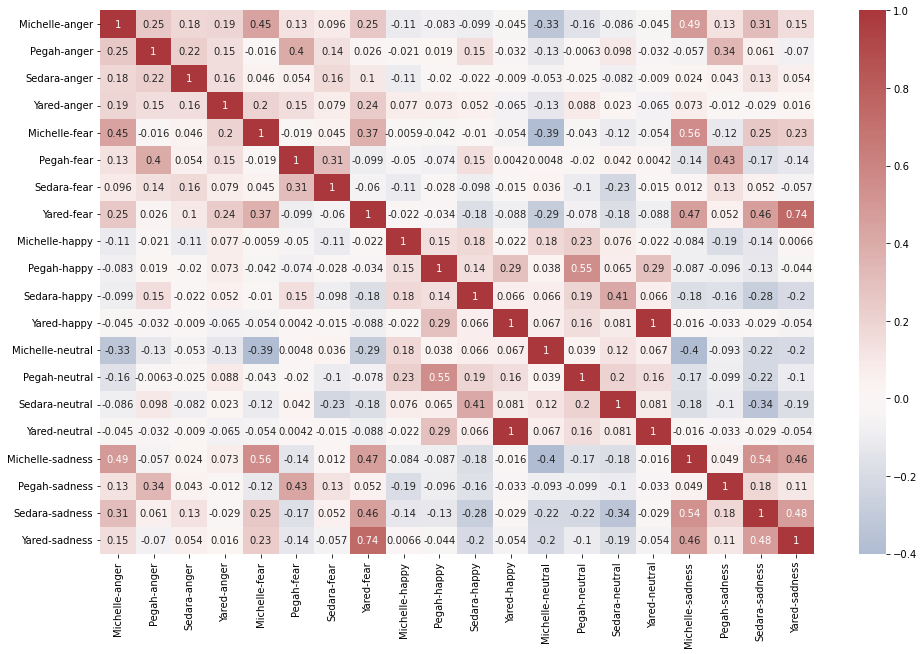

In [15]:
correlations = ratings_across_files.T.corr()
plt.figure(figsize=(16,10))
sns.heatmap(correlations, center=0, cmap='vlag', annot=True)
plt.savefig('heatmap.png')
plt.show()

In [16]:
correlations

,Michelle-anger,Pegah-anger,Sedara-anger,Yared-anger,Michelle-fear,Pegah-fear,Sedara-fear,Yared-fear,Michelle-happy,Pegah-happy,Sedara-happy,Yared-happy,Michelle-neutral,Pegah-neutral,Sedara-neutral,Yared-neutral,Michelle-sadness,Pegah-sadness,Sedara-sadness,Yared-sadness
Michelle-anger,1.000000,0.254246,0.182232,0.193689,0.449646,0.125066,0.095943,0.251253,-0.110957,-0.083483,-0.098997,-0.044942,-0.332234,-0.157988,-0.085991,-0.044942,0.486977,0.127069,0.305013,0.151587
Pegah-anger,0.254246,1.000000,0.221033,0.153512,-0.015761,0.402555,0.137687,0.025921,-0.020770,0.019117,0.152241,-0.032232,-0.126435,-0.006349,0.098368,-0.032232,-0.056577,0.342026,0.061027,-0.070468
Sedara-anger,0.182232,0.221033,1.000000,0.155524,0.046253,0.053742,0.163625,0.100671,-0.105170,-0.019747,-0.021514,-0.009044,-0.052712,-0.025075,-0.082324,-0.009044,0.024177,0.042810,0.130377,0.053761
Yared-anger,0.193689,0.153512,0.155524,1.000000,0.202098,0.153136,0.079487,0.242060,0.076934,0.072786,0.051958,-0.064503,-0.134118,0.087573,0.023292,-0.064503,0.073424,-0.011568,-0.028790,0.015927
Michelle-fear,0.449646,-0.015761,0.046253,0.202098,1.000000,-0.018779,0.044999,0.367399,-0.005926,-0.042015,-0.010114,-0.053724,-0.394882,-0.042873,-0.116387,-0.053724,0.559091,-0.121683,0.254121,0.229013
Pegah-fear,0.125066,0.402555,0.053742,0.153136,-0.018779,1.000000,0.308259,-0.099198,-0.050035,-0.073603,0.150701,0.004239,0.004810,-0.020194,0.041751,0.004239,-0.142912,0.426302,-0.172043,-0.137895
Sedara-fear,0.095943,0.137687,0.163625,0.079487,0.044999,0.308259,1.000000,-0.059928,-0.107765,-0.028324,-0.098013,-0.014976,0.036083,-0.103050,-0.231274,-0.014976,0.011619,0.134841,0.052097,-0.056706
Yared-fear,0.251253,0.025921,0.100671,0.242060,0.367399,-0.099198,-0.059928,1.000000,-0.021745,-0.033732,-0.182192,-0.087643,-0.287168,-0.078315,-0.178778,-0.087643,0.466832,0.051677,0.462235,0.737376
Michelle-happy,-0.110957,-0.020770,-0.105170,0.076934,-0.005926,-0.050035,-0.107765,-0.021745,1.000000,0.149312,0.175954,-0.022087,0.175950,0.226139,0.076077,-0.022087,-0.084035,-0.191081,-0.135614,0.006638
Pegah-happy,-0.083483,0.019117,-0.019747,0.072786,-0.042015,-0.073603,-0.028324,-0.033732,0.149312,1.000000,0.144057,0.288475,0.038009,0.548409,0.064941,0.288475,-0.086534,-0.096459,-0.129814,-0.043908
